In [1]:
#Imports
from local_lib.ManualNeuralNetwork.lmnn.model_gpu import lmnn
from local_lib.ManualNeuralNetwork.lmnn.layers.dense_gpu import DenseGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.layers.dropout_gpu import DropoutGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.layers.output_gpu import OutputGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.activations.sigmoid_gpu import SigmoidGpuActivation
from local_lib.ManualNeuralNetwork.lmnn.activations.relu_gpu import ReluGpuActivation
from local_lib.ManualNeuralNetwork.lmnn.initializers.xavier_gpu import XavierGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.initializers.random_gpu import RandomGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.initializers.he_gpu import HeGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.loss.bce_gpu import BceGpuLoss
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
from local_lib.neural_network_classic_batch import NeuralNetworkMultiLayerClassicStrat
from sklearn.decomposition import PCA
import copy
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from local_lib.plotting import plotHist, plotDecisionBoundaries

In [2]:
dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

In [3]:
pipeline = Pipeline([
    ('flatten_tr', FlattenTransformer()),
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('dimension_tr', DimensionTransformer())])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=0)

In [4]:
import numpy as np
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
X_train_pca = X_train_pca.T
X_test_pca = X_test_pca.T

In [5]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('minmax', MinMaxScaler())])

X_train_pca = pipeline.fit_transform(X_train_pca)
X_test_pca = pipeline.fit_transform(X_test_pca)

In [6]:
import copy

# Make a copy of the list
y_train_simpler = copy.deepcopy(y_train)
y_train_simpler[y_train_simpler == 2] = 1

y_test_simpler = copy.deepcopy(y_test)
y_test_simpler[y_test_simpler == 2] = 1

print(np.unique(y_train_simpler))
print(np.unique(y_test_simpler))

[0 1]
[0 1]


In [7]:
import numpy as np

# Création de la matrice identité
identity_matrix = np.eye(3)
identity_matrix_simpler = np.eye(2)

# Transformation de t1 en t2
y_train_reshaped = identity_matrix[y_train[0]].T
y_test_reshaped = identity_matrix[y_test[0]].T

y_train_simpler_reshaped = identity_matrix_simpler[y_train_simpler[0]].T
y_test_simpler_reshaped = identity_matrix_simpler[y_test_simpler[0]].T

print(y_train_reshaped.shape)
print(y_test_simpler_reshaped.shape)

(3, 3923)
(2, 1933)


In [8]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 8),
    DenseGpuLayer(SigmoidGpuActivation(), XavierGpuInitializer(), 8),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.01, patience=400, strategy="sub", sub_parts=5)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

 28%|██▊       | 159/559 [00:04<00:10, 37.17it/s]


In [9]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.7320227625452664
Least recall :0.7320227625452664
Least precision :0.8038345623391371


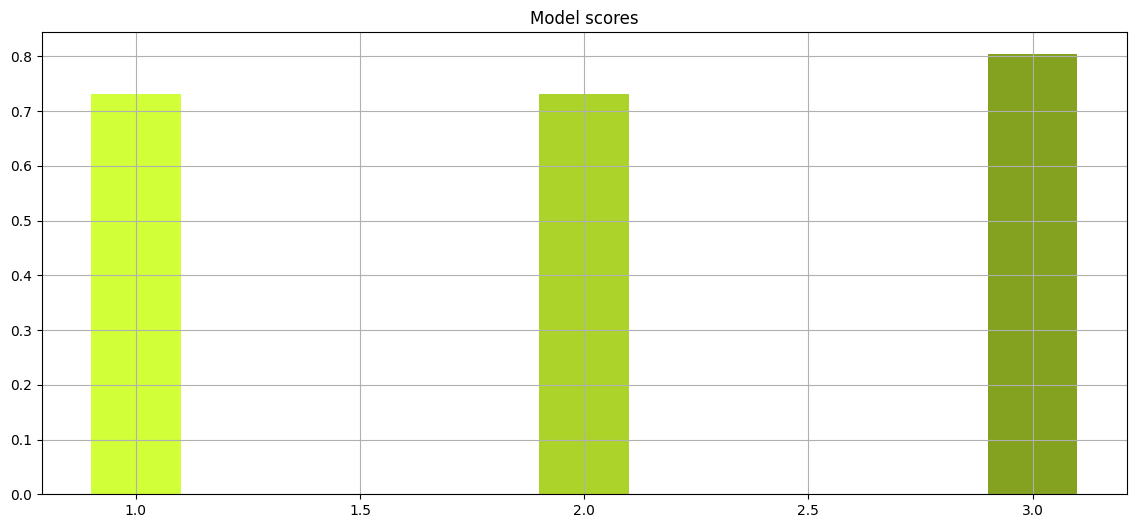

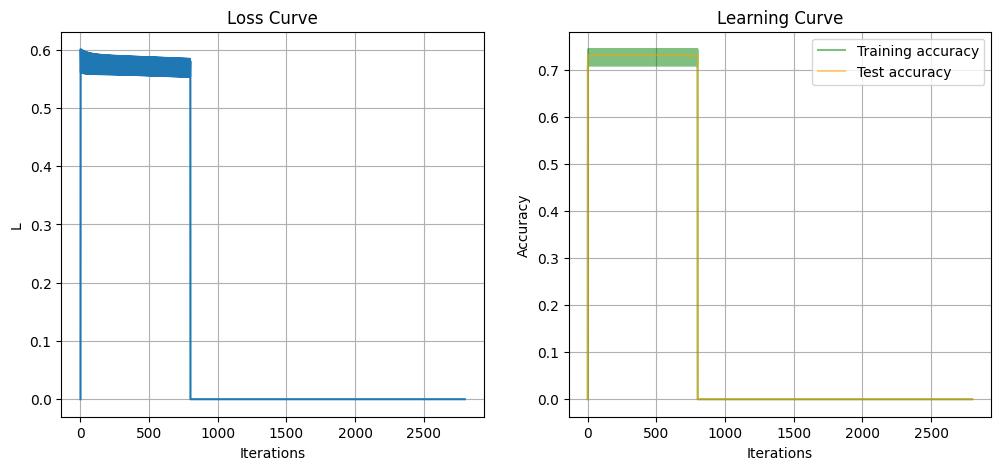

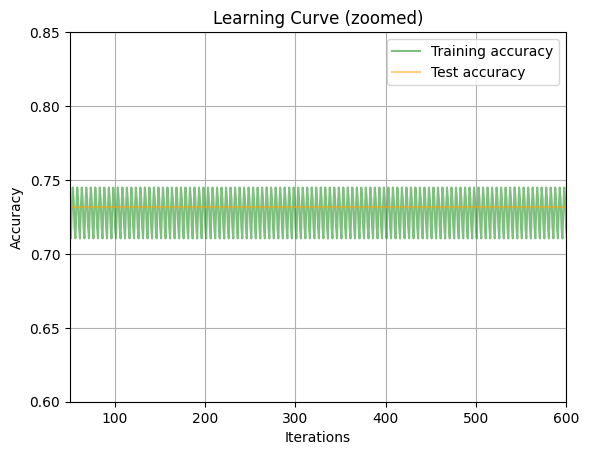

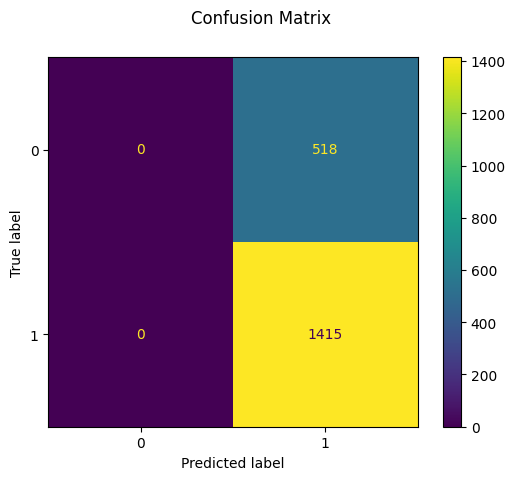

In [10]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [11]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), XavierGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.01, patience=400, strategy="sub", sub_parts=2)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 1399/1399 [00:12<00:00, 113.68it/s]


In [13]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.9136057941024315
Least recall :0.9136057941024315
Least precision :0.9124995011735476


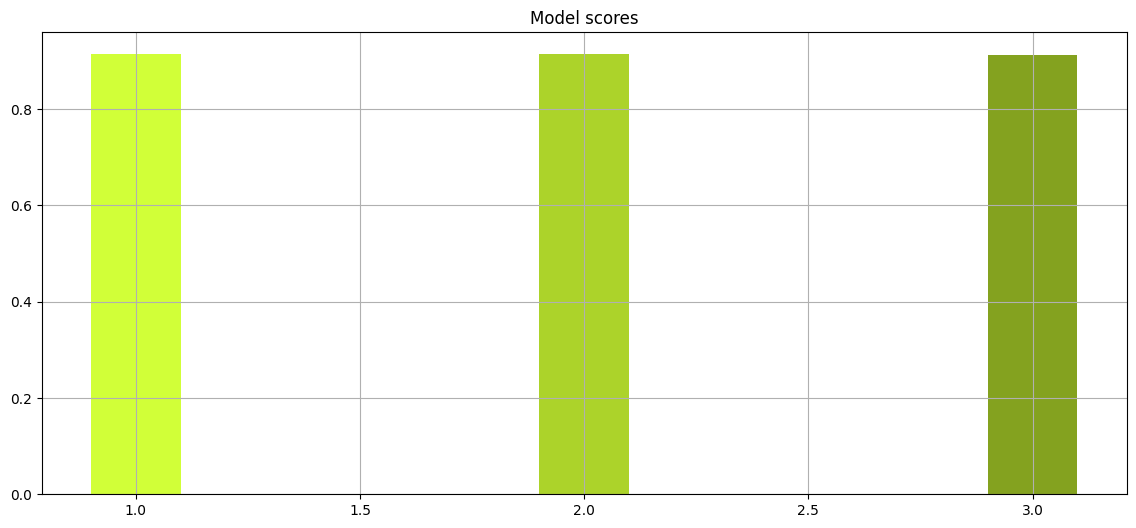

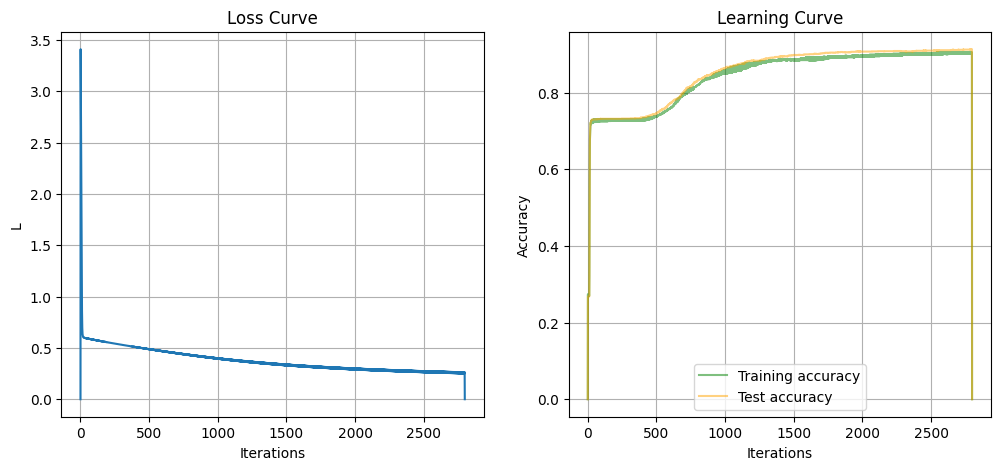

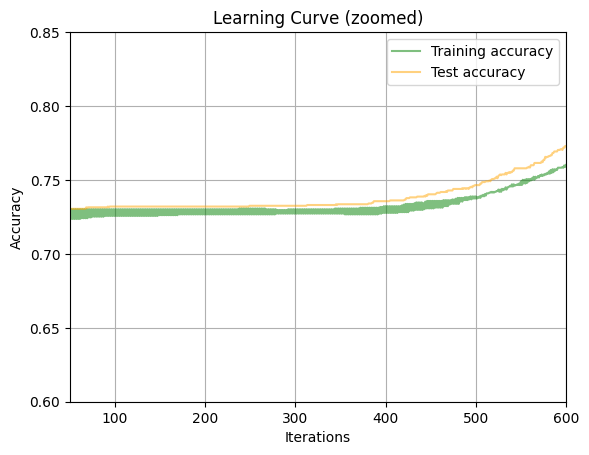

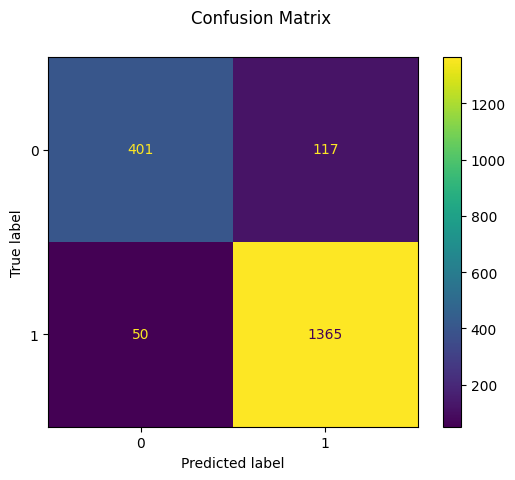

In [14]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [15]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), XavierGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), XavierGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.01, patience=400, strategy="sub", sub_parts=2)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

 29%|██▊       | 399/1399 [00:04<00:11, 90.38it/s] 


In [16]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.7320227625452664
Least recall :0.7320227625452664
Least precision :0.8038345623391371


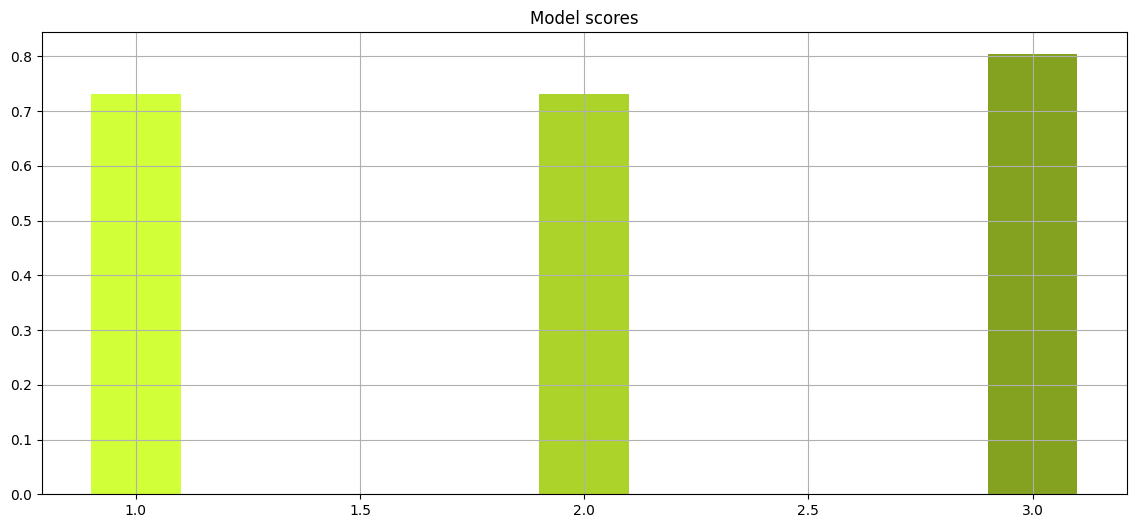

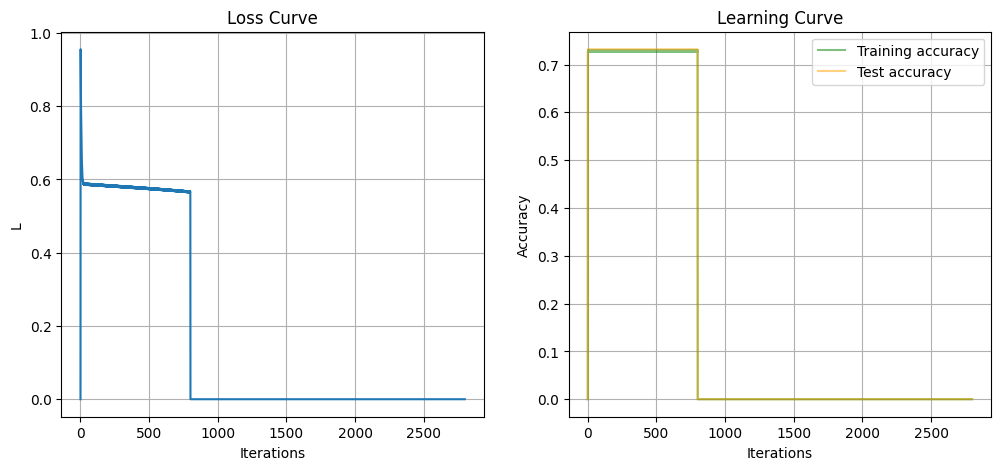

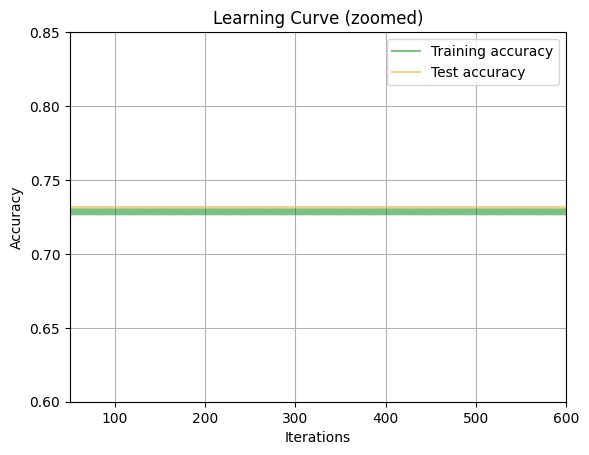

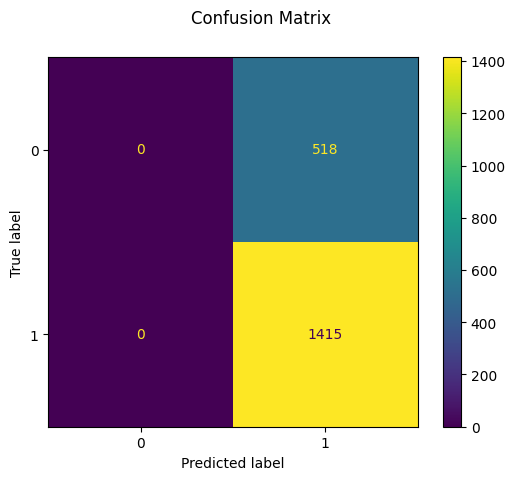

In [17]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [24]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), XavierGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=5000, lr=0.019, patience=5000, strategy="sub", sub_parts=5)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 999/999 [00:24<00:00, 40.19it/s]


In [25]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.9322296947749612
Least recall :0.9322296947749612
Least precision :0.9321887660791517


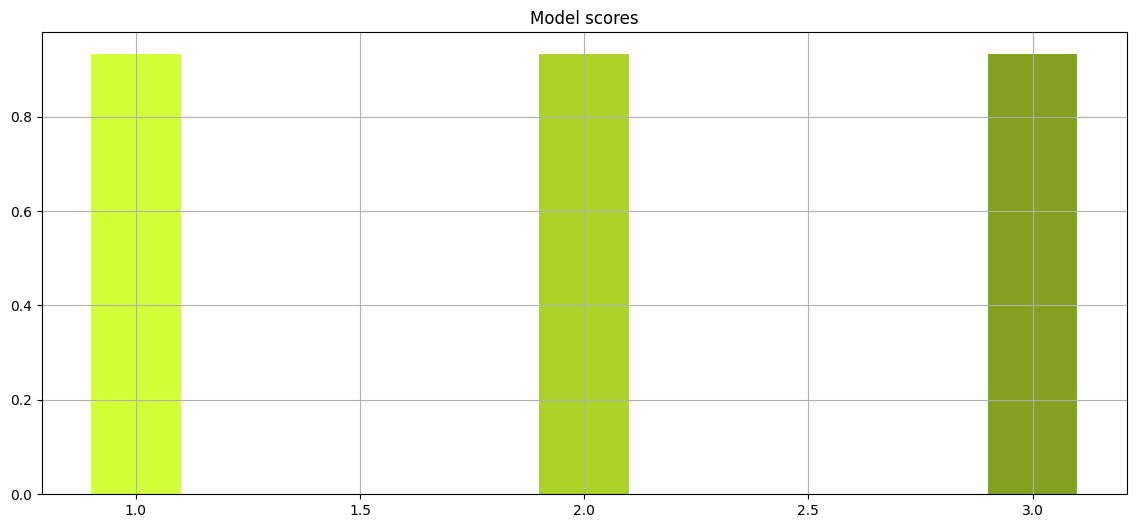

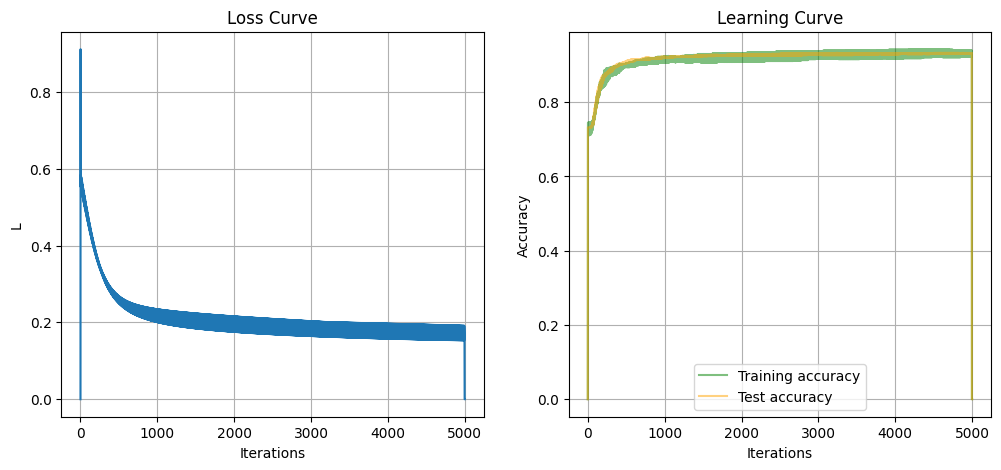

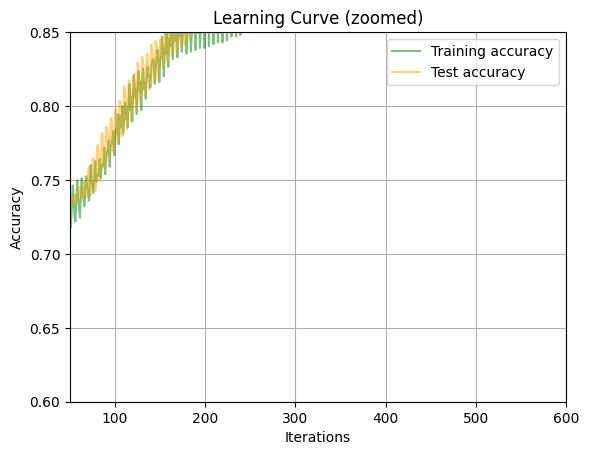

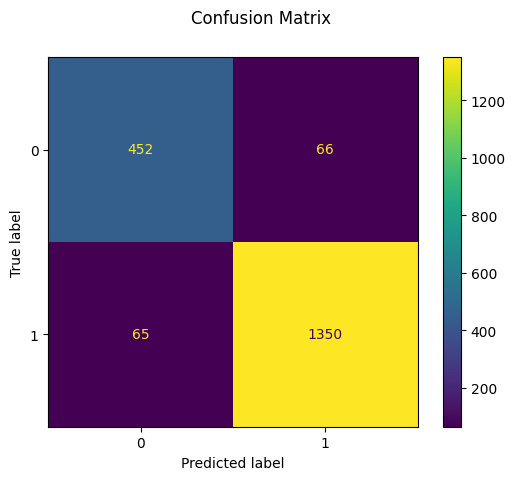

In [26]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [27]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=6000, lr=0.01, patience=6000, strategy="sub", sub_parts=5)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 1199/1199 [00:37<00:00, 31.60it/s]


In [28]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.7320227625452664
Least recall :0.7320227625452664
Least precision :0.8038345623391371


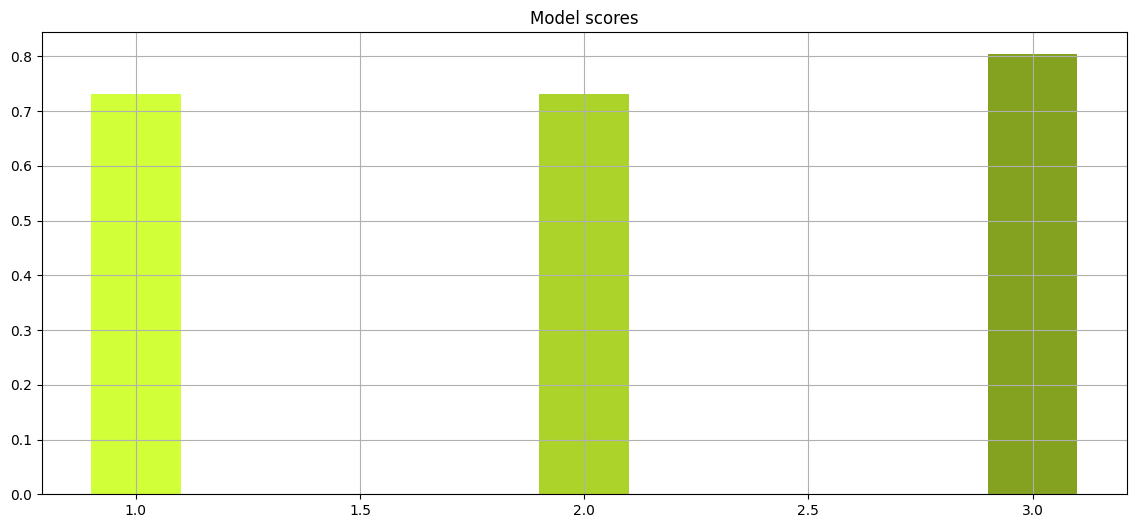

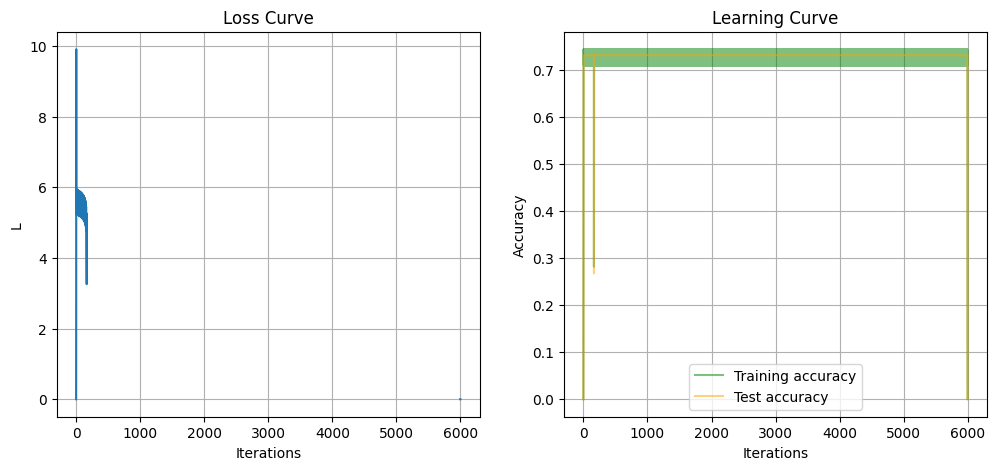

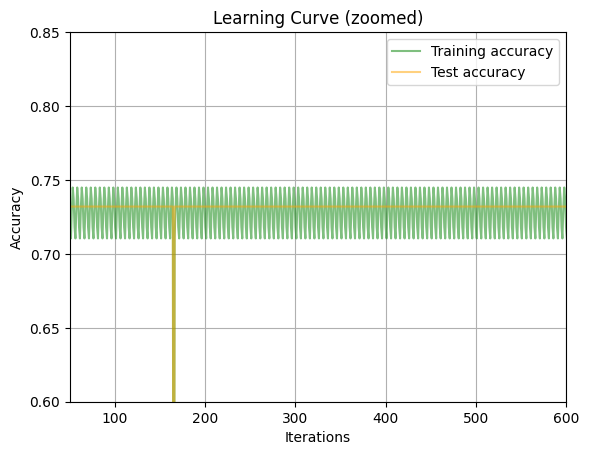

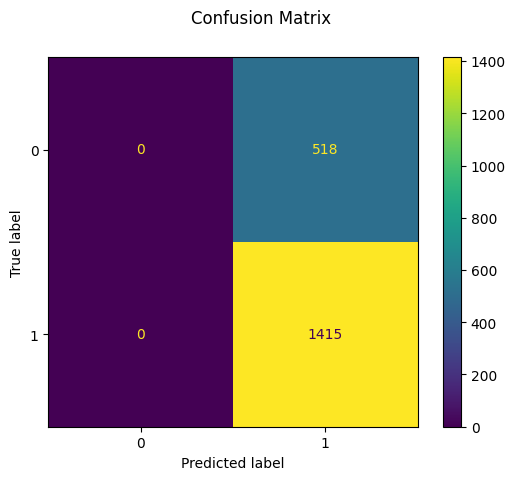

In [29]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [ ]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.01, patience=250, strategy="sub", sub_parts=5)

model.fit(X_train, X_test, y_train_simpler_reshaped, y_test_simpler_reshaped)

In [58]:
y_pred = model.predict(X_test)

Least accuracy :0.8489761092150171
Least recall :0.8489761092150171
Least precision :0.8444671975729997


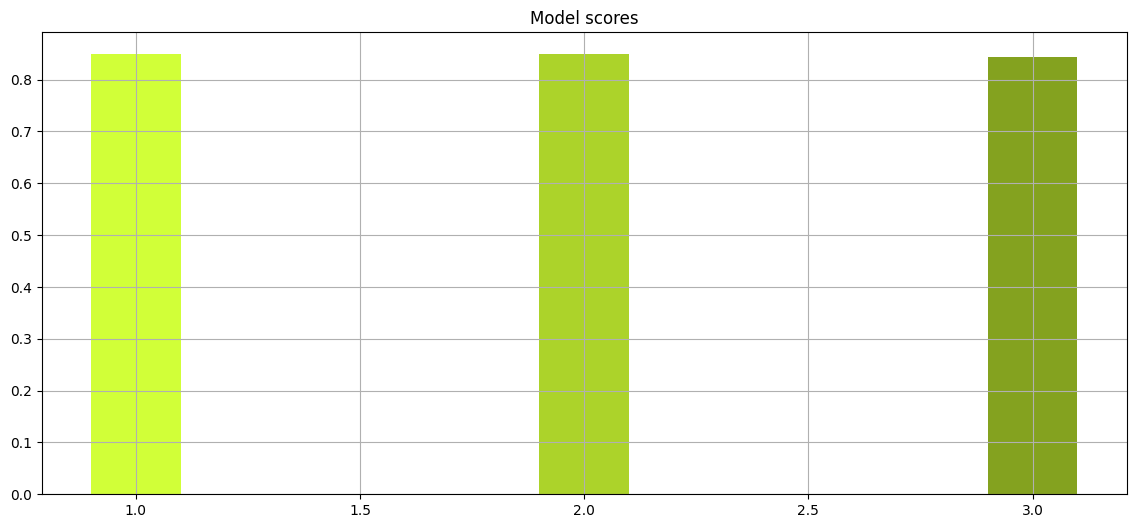

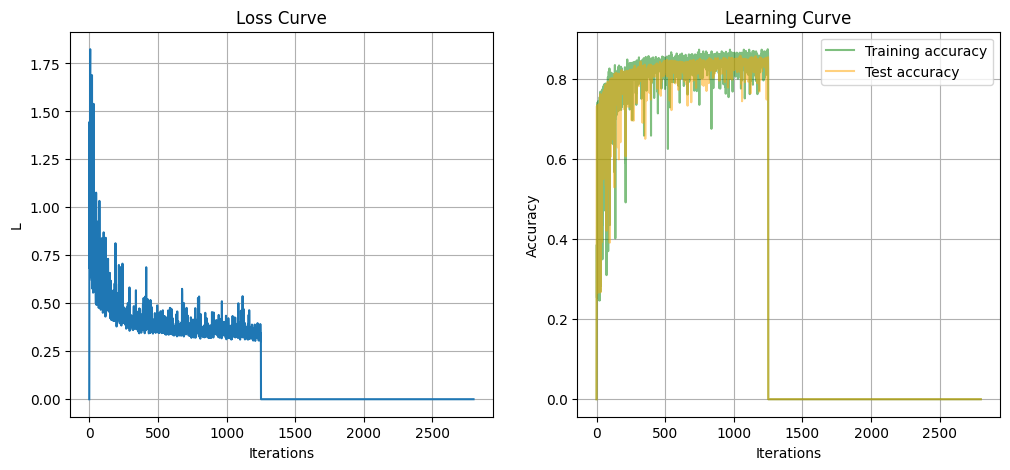

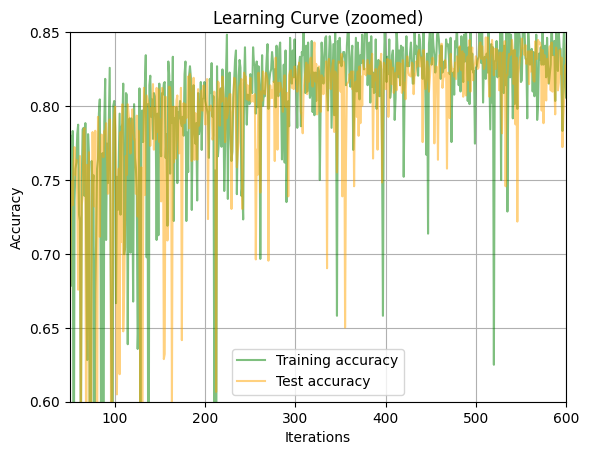

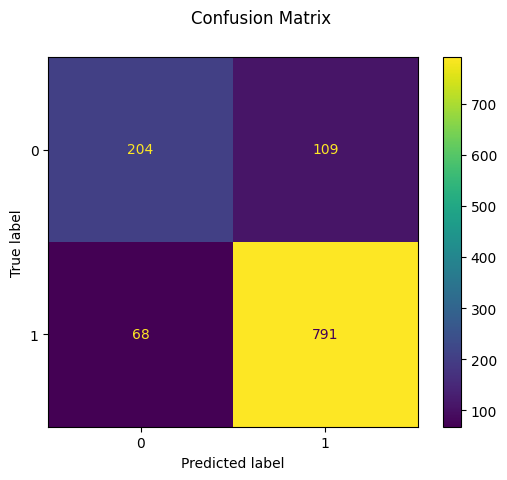

In [59]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [60]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), XavierGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 128),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.019, patience=250, strategy="sub", sub_parts=5)

model.fit(X_train, X_test, y_train_simpler_reshaped, y_test_simpler_reshaped)

 45%|████▍     | 249/559 [01:41<02:06,  2.45it/s]


In [61]:
y_pred = model.predict(X_test)

Least accuracy :0.8139931740614335
Least recall :0.8139931740614335
Least precision :0.8064585489037742


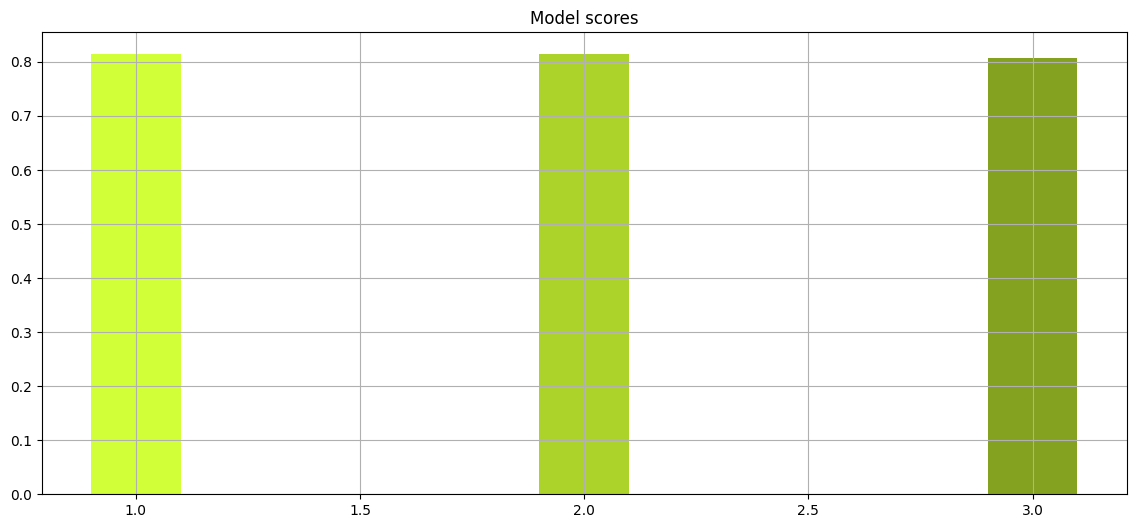

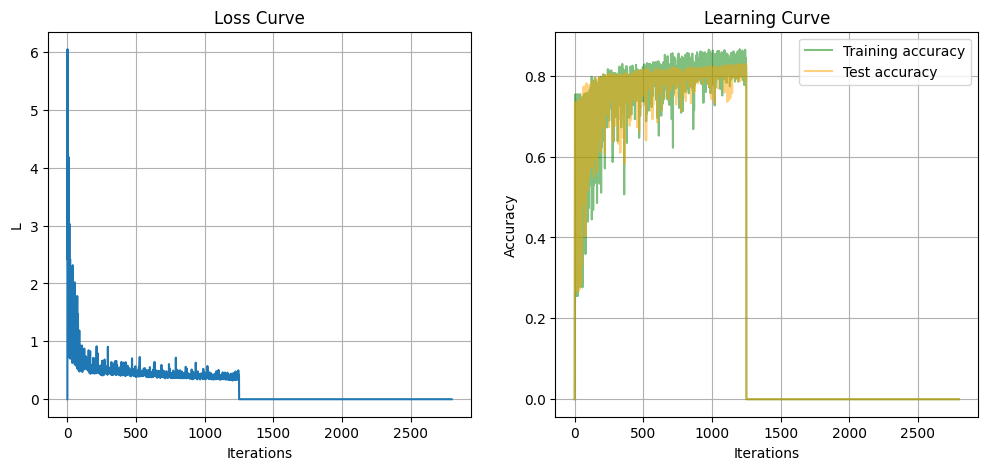

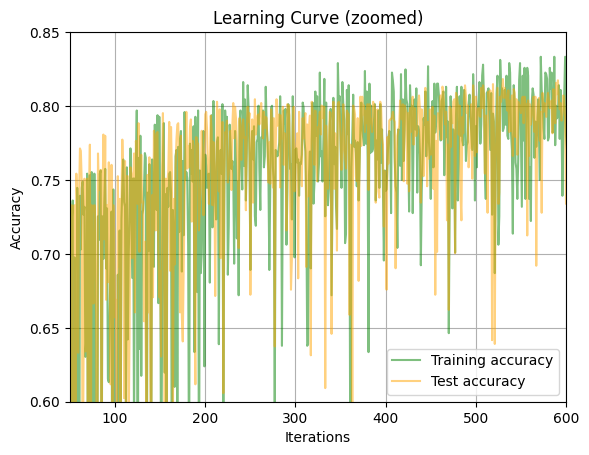

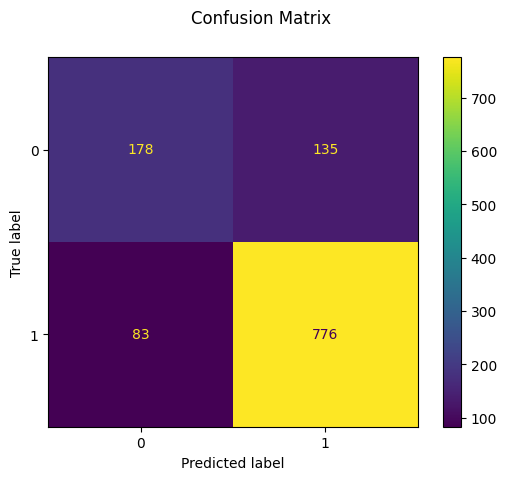

In [62]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [66]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 128),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.019, patience=1800, strategy="sub", sub_parts=5)

model.fit(X_train, X_test, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 559/559 [03:44<00:00,  2.49it/s]


In [67]:
y_pred = model.predict(X_test)

Least accuracy :0.8745733788395904
Least recall :0.8745733788395904
Least precision :0.8767331762036624


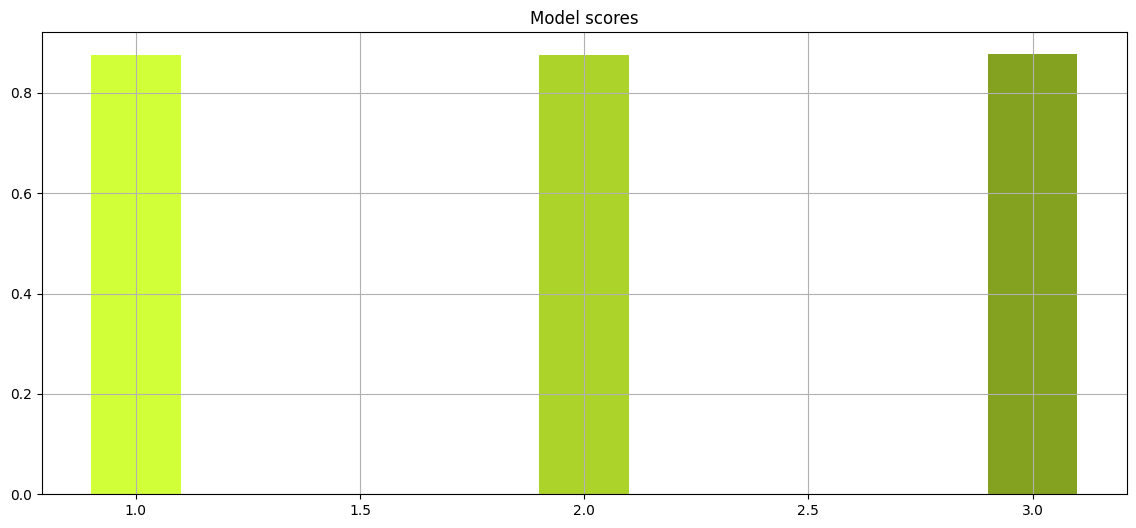

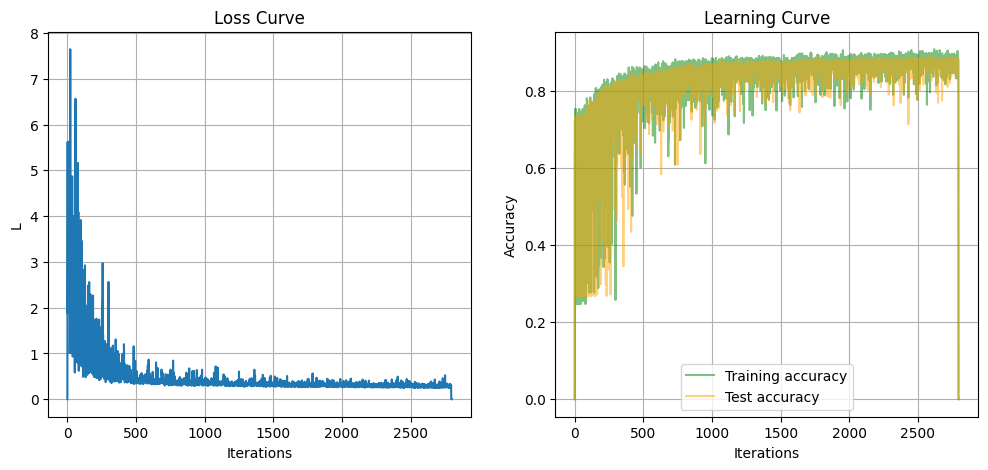

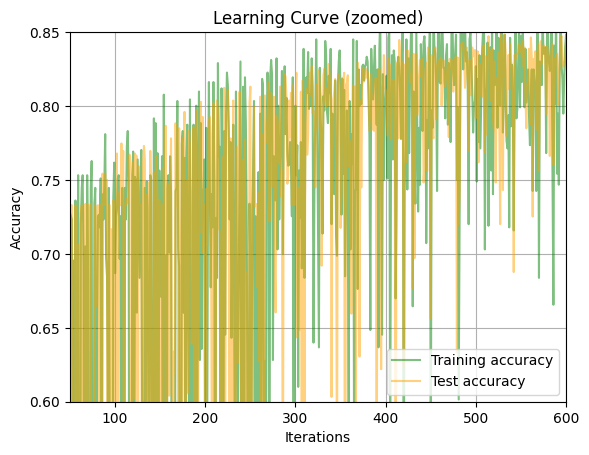

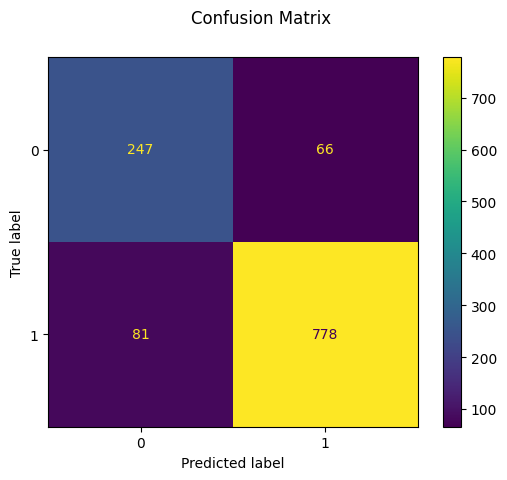

In [68]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))

In [69]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.019, patience=1800, strategy="sub", sub_parts=5)

model.fit(X_train, X_test, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 559/559 [03:44<00:00,  2.49it/s]


In [70]:
y_pred = model.predict(X_test)

Least accuracy :0.8745733788395904
Least recall :0.8745733788395904
Least precision :0.8739004861065927


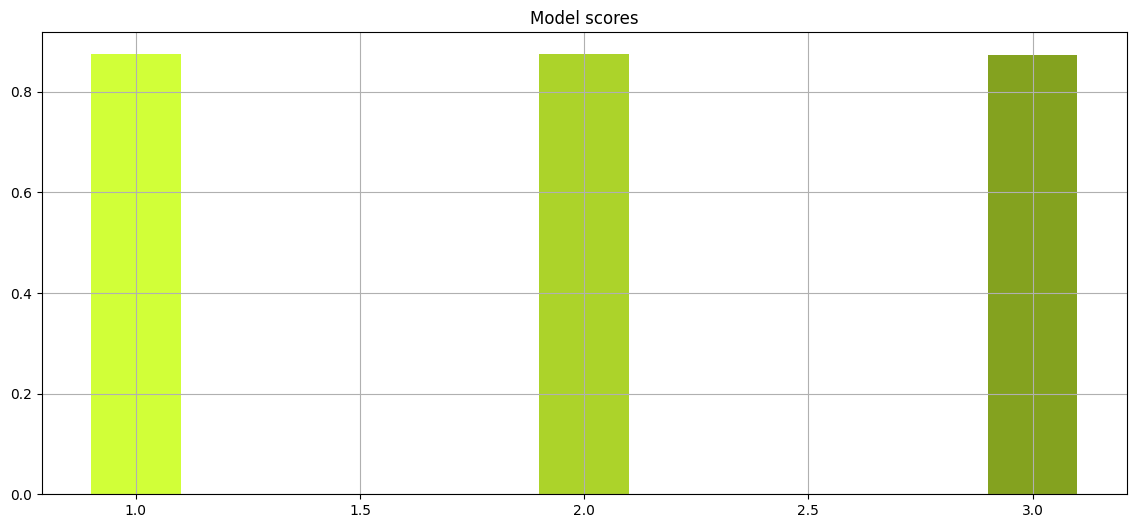

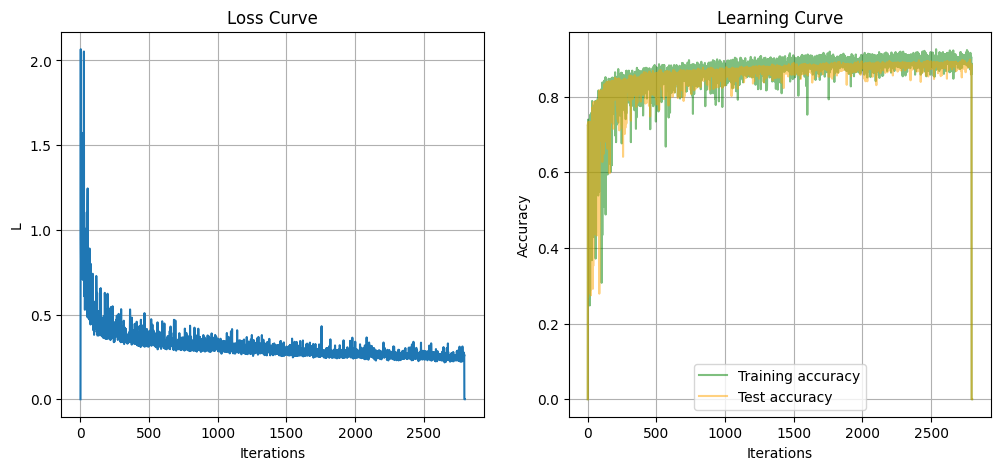

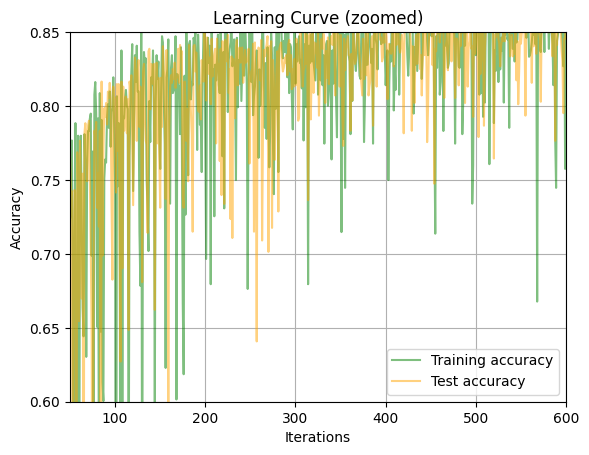

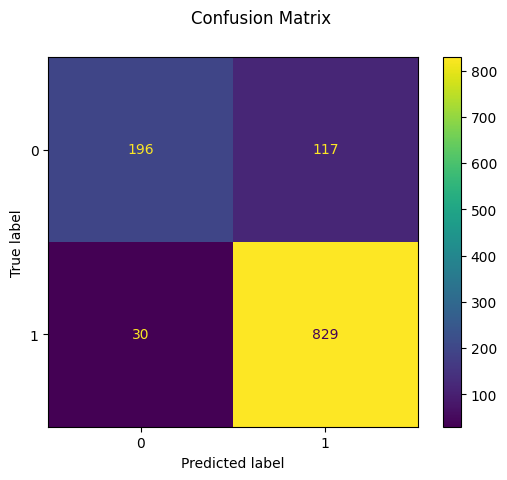

In [71]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))